In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')

plt.rc(

    'figure',
    figsize=(12,5),
    autolayout = True
)

plt.rc(

    "axes",
    labelsize=16,
    labelweight = 'bold',
    titlesize = 18,
    titleweight = 'bold'
)
plot_params  = dict(
    color = '0.75',
    markeredgecolor = '0.25',
    markerfacecolor = '0.25',
    style = '.-',
    legend = True

)

In [2]:
data = pd.read_csv('/Users/apple/Desktop/New/datasets/monthly-beer-production-in-austr.csv')

data.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [3]:
data.shape

(476, 2)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [5]:
df = data.copy()

df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [6]:
df.rename(columns = {'Month': 'Date'}, inplace=True)

In [7]:
df.head()

,Date,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].apply(lambda x: x.month)
df['Year'] = df['Date'].apply(lambda x: x.year)
df = df.set_index('Date')
df.resample('M').mean()

df['Month_name'] = df.index.strftime('%b')
df.head()

,Monthly beer production,Month,Year,Month_name
Date,,,,
1956-01-01,93.2,1,1956,Jan
1956-02-01,96.0,2,1956,Feb
1956-03-01,95.2,3,1956,Mar
1956-04-01,77.1,4,1956,Apr
1956-05-01,70.9,5,1956,May


In [10]:
df_up = df[['Monthly beer production']]

df_up.head()

,Monthly beer production
Date,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


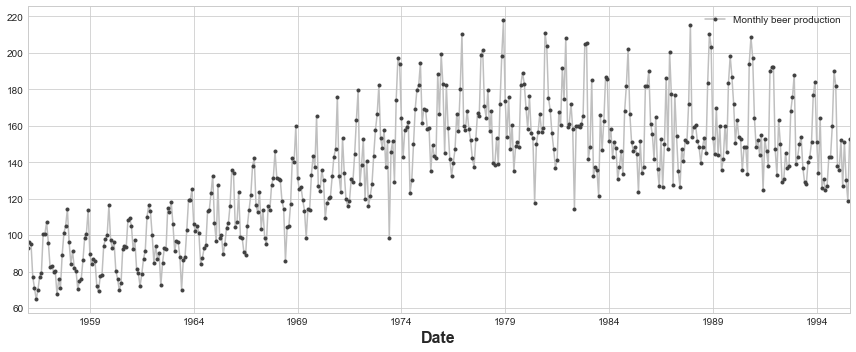

In [11]:
df_up.plot(**plot_params)
plt.show()

In [12]:
import plotly.express as px

In [13]:
fig = px.box(data_frame = df, x = 'Monthly beer production')
fig.show()

There are outliers in the dataset.

In [14]:
df_up.index.dtype

dtype('<M8[ns]')

The skewness of the distribution is:  -0.03592253940022188


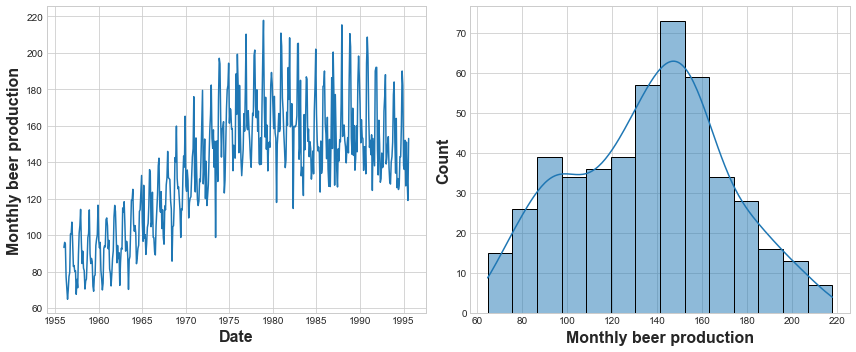

In [16]:
def hist_plot(ts):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5))
    sns.histplot()
    sns.lineplot(data = ts, ax = ax0)
    sns.histplot(data = ts, kde=True, ax = ax1)
    print('The skewness of the distribution is: ', ts.skew())

hist_plot(df['Monthly beer production'])

In [19]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method = 'box-cox', standardize=False)

box_cox_close = pd.Series(pt.fit_transform(df['Monthly beer production'].to_numpy().reshape(-1, 1)).ravel())

The skewness of the distribution is:  -0.059702934674103564


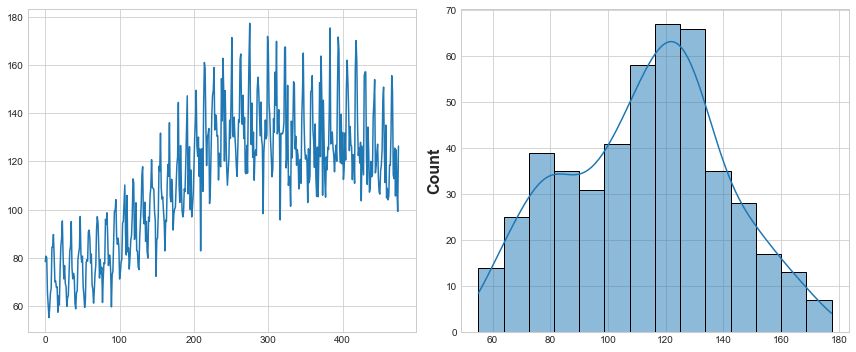

In [20]:
hist_plot(box_cox_close)

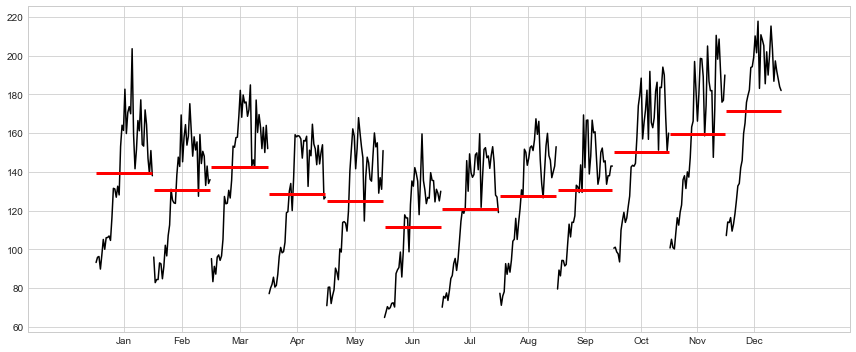

In [22]:
mp = month_plot(df['Monthly beer production'])
mp.show()

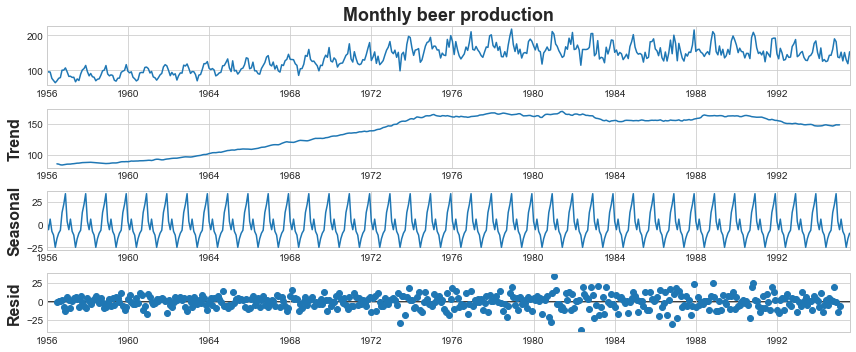

In [26]:
r = seasonal_decompose(df['Monthly beer production'])
r.plot();

In [37]:
dp = DeterministicProcess(index = df.index, order = 1, constant =True, drop = True)

X = dp.in_sample()
X

,const,trend
Date,,
1956-01-01,1.0,1.0
1956-02-01,1.0,2.0
1956-03-01,1.0,3.0
1956-04-01,1.0,4.0
1956-05-01,1.0,5.0
...,...,...
1995-04-01,1.0,472.0
1995-05-01,1.0,473.0
1995-06-01,1.0,474.0


In [38]:
y = df['Monthly beer production']

In [39]:
reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

In [40]:
y_pred = pd.Series(reg.predict(X), index = X.index)
y_pred[:10]

Date
1956-01-01    95.482517
1956-02-01    95.654781
1956-03-01    95.827046
1956-04-01    95.999311
1956-05-01    96.171575
1956-06-01    96.343840
1956-07-01    96.516105
1956-08-01    96.688370
1956-09-01    96.860634
1956-10-01    97.032899
dtype: float64

TypeError: unhashable type: 'list'

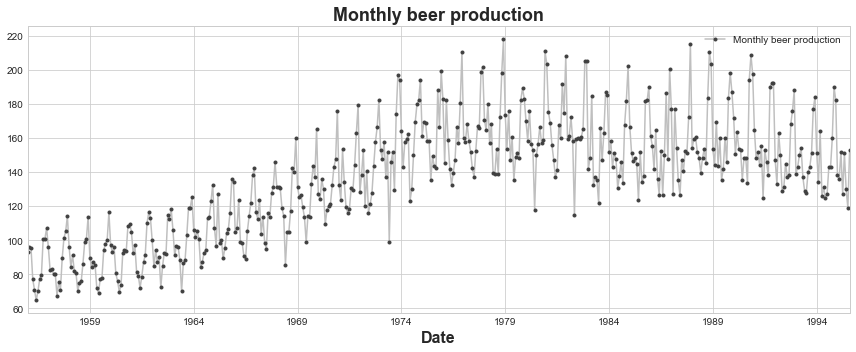

In [41]:
fig, ax = plt.subplots(figsize=(12,5))
ax = y.plot(**plot_params, title = 'Monthly beer production')
y_pred.plot(ax = ax, linewdith = 0.3, color = 'C3', label = ['Forecast'])